## Calculate Tau for Lowman Sentinel 1 coherences between Jan 1 2021 and April 1 2021

In [1]:
from os.path import join, expanduser, basename
from glob import glob
import numpy as np
import xarray as xa
import rioxarray as rxa
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from scipy.optimize import curve_fit

In [2]:
def temp_model(T, tau):
    return np.exp(-T/tau)

def tau(cors, days):
    if np.sum(np.isnan(cors)) == 0:
        s = curve_fit(temp_model, days, cors, 5)[0][0]
        return s
    else:
        return np.nan

In [3]:
s1ds = glob(join(expanduser('~/scratch/data/uavsar/sentinel/'), 'S1*VV*'))

In [4]:
c1 = rxa.open_rasterio(glob(join(s1ds[0], '*corr.tif'))[0]).rio.reproject('EPSG:4326').rio.clip_box(-115.3, 44.2, -115.05, 44.4)
cor_vv_arr = np.zeros((len(s1ds), *c1.values[0].shape))

###### removed S1AB_20210223T134938_20210325T134856_VVP030_INT40_G_ueF_A344
corrupted file.

In [5]:
for i, fps in tqdm(enumerate(s1ds), total = len(s1ds)):
        c2 = rxa.open_rasterio(glob(join(fps, '*corr.tif'))[0]).rio.reproject_match(c1)
        cor_vv_arr[i] = c2.values[0]

100%|██████████| 164/164 [01:31<00:00,  1.80it/s]


In [6]:
days = [int(d.split('_')[-5].replace('VVP','')) for d in s1ds]

In [19]:
taus = np.apply_along_axis(arr = cor_vv_arr, func1d = tau, axis = 0, days = days)

In [21]:
c1.values[0] = taus

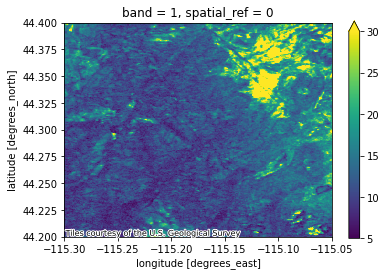

In [37]:
import contextily as ctx
f, ax= plt.subplots()
c1.plot(ax = ax, alpha = 1, vmin = 5, vmax = 30)
ctx.add_basemap(ax = ax, source = ctx.providers.USGS.USTopo, crs = 'EPSG:4326')

In [ ]:
c1.rio.to_raster(join('/bsuhome/zacharykeskinen/uavsar/results/taus','s1_lowman.tif'))